In [1]:
import time
import numpy as np
import pickle
import sys
import os
import pybullet as p
from init import *
from utils.tools import *
from modules.RRTstar import *
import pybullet_data
from modules.simple_control import *
from modules.dwa import *
import copy
from modules.roboEnv import *
import os

In [2]:
# connect pybullet and initialize
physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
root_dir = os.path.join(os.path.dirname(os.path.realpath('file')),"../")
obstacle_ids = init_scene(p)
robotId = load_robot(p)
dy_obs = p.loadURDF("cube.urdf", [-1, 0.5, 0], globalScaling = 0.2)
p.setTimeStep(1.0 / 240.0)
# p.setRealTimeSimulation(1)

In [3]:
right_front_wheel_joint = 2
right_back_wheel_joint = 3
left_front_wheel_joint = 6
left_back_wheel_joint = 7
base_wheels = [2,3,6,7]
left_wheels = [left_back_wheel_joint, left_front_wheel_joint]
right_wheels = [right_front_wheel_joint, right_back_wheel_joint]
xmin, xmax = -1.5, 3.5  # x轴范围
ymin, ymax = -4.5, 0.5  # y轴范围
obstacle_aabbs = [p.getAABB(obstacle_id) for obstacle_id in obstacle_ids]
obstacle_aabbs.append(((0.2, -3.8, 0.0),(1.1, -2.7,1.)))
target_body_id = None
path_node_id = []
dy_obstacle_ids = copy.deepcopy(obstacle_ids)
# dy_obstacle_ids.append(dy_obs)
dy_obs_path = [(-1., 0.5), (-1., -1.5), (0.5, -1.5), (0.5, -2.5), (-1.5, -2.5), (-0.5, -4.),(0., -4.5), (-0.5, -4.),(-1.5, -2.5),(0.5, -2.5),(0.5, -1.5), (-1., -1.5)]

In [4]:
available_position = []
for x in range(-8, 17, 1):
    for y in range(-24, 5, 1):
        target_point = [x*0.25, y*0.25]        
        is_valid = True
        for aabb_min, aabb_max in obstacle_aabbs:
            if is_point_in_aabb(target_point, aabb_min, aabb_max, clearance=0.2):
                is_valid = False
                break
        if is_valid:
            available_position.append((x,y))

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.fc(state)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.fc(state)


In [6]:
def sample_trajectories(env, policy_net, max_steps=1000, gamma=0.99, reset_target=False):
    states, actions, rewards, log_probs, dones = [], [], [], [], []
    state = env.reset(reset_target=reset_target)
    
    for _ in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = policy_net(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        
        next_state, reward, done = env.step(action.item())
        
        # 存储轨迹
        states.append(state)
        actions.append(action.item())
        rewards.append(reward)
        log_probs.append(action_dist.log_prob(action).item())
        dones.append(done)
        
        state = next_state
        if done:
            break
    
    # 计算折扣奖励
    returns = []
    g = 0
    for r, done in zip(reversed(rewards), reversed(dones)):
        g = r + gamma * g * (1 - done)
        returns.insert(0, g)
    
    return states, actions, rewards, log_probs, returns, dones

def compute_advantages(returns, values, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    for t in reversed(range(len(returns))):
        delta = returns[t] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    return advantages

def ppo_loss(new_log_probs, old_log_probs, advantages, epsilon=0.2):
    ratios = torch.exp(new_log_probs - old_log_probs)
    clipped_ratios = torch.clamp(ratios, 1 - epsilon, 1 + epsilon)
    loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
    return loss


In [7]:
total_rewards = []
policy_losses = []
value_losses = []

In [8]:
def train_ppo(env, policy_net, value_net, num_epochs=100, max_steps=1000, batch_size=64, gamma=0.99, lam=0.95, epsilon=0.2, policy_lr=3e-4, value_lr=1e-3):
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    reset_target = False

    for epoch in range(num_epochs):
        # sample traj
        states, actions, rewards, log_probs, returns, dones = sample_trajectories(env, policy_net, max_steps, gamma, reset_target)
        
        if dones:
            reset_target = dones[-1]
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        
        # compute advantage
        values = value_net(states_tensor).view(-1)
        advantages = compute_advantages(returns, values.detach().numpy(), gamma, lam)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32)

        # update policy
        for _ in range(5):
            action_probs = policy_net(states_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            new_log_probs = action_dist.log_prob(actions_tensor)
            
            loss = ppo_loss(new_log_probs, torch.tensor(log_probs, dtype=torch.float32), advantages_tensor, epsilon)
            policy_optimizer.zero_grad()
            loss.backward()
            policy_optimizer.step()
        
        # update value
        value_loss_fn = nn.MSELoss()
        value_loss = value_loss_fn(values, returns_tensor)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
        
        # print log
        print(f"Epoch {epoch}, Total Reward: {sum(rewards)}, Policy Loss: {loss.item()}, Value Loss: {value_loss.item()}, Done: {dones[-1]}")
        total_rewards.append(sum(rewards))
        policy_losses.append(loss.item())
        value_losses.append(value_loss.item())


In [9]:
def test_model(env, policy_net):
    states, actions, rewards, log_probs, dones = [], [], [], [], []
    state = env.reset(reset_target=False)
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = policy_net(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        
        next_state, reward, done = env.step(action.item())
        
        states.append(state)
        actions.append(action.item())
        rewards.append(reward)
        log_probs.append(action_dist.log_prob(action).item())
        dones.append(done)
        
        state = next_state
        if done:
            break

In [10]:
# init env and network
env = RobotEnv(robotId, obstacle_ids, dy_obs, target_position=(0.5, -2, 0), available_position=available_position)
state_dim = 8
action_dim = 8
policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)
# policy_net.load_state_dict(torch.load(os.path.join("models", "policy_net_600.pth")))
# value_net.load_state_dict(torch.load(os.path.join("models", "value_net_600.pth")))

In [11]:
# training
start_epochs = 0
num_epochs = 600
train_ppo(env, policy_net, value_net, num_epochs - start_epochs)
torch.save(policy_net.state_dict(), f"policy_net_{num_epochs}.pth")
torch.save(value_net.state_dict(), f"value_net_{num_epochs}.pth")


C:\Users\13054\AppData\Local\Temp\ipykernel_31432\1209542542.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states_tensor = torch.tensor(states, dtype=torch.float32)


Epoch 0, Total Reward: -6768686.093694232, Policy Loss: 10032284.0, Value Loss: 393374629888.0, Done: False
Epoch 1, Total Reward: -6721516.475847471, Policy Loss: 10004248.0, Value Loss: 386775154688.0, Done: False
Epoch 2, Total Reward: -6645322.236459611, Policy Loss: 9853621.0, Value Loss: 379195981824.0, Done: False
Epoch 3, Total Reward: -6658119.715302133, Policy Loss: 9960601.0, Value Loss: 381078568960.0, Done: False
Epoch 4, Total Reward: -6612824.418010421, Policy Loss: 9835772.0, Value Loss: 374649290752.0, Done: False
Epoch 5, Total Reward: -6676350.758196067, Policy Loss: 9911870.0, Value Loss: 381215637504.0, Done: False
Epoch 6, Total Reward: -6659823.431737553, Policy Loss: 9904366.0, Value Loss: 378657865728.0, Done: False
Epoch 7, Total Reward: -6542981.36007965, Policy Loss: 9819263.0, Value Loss: 369662066688.0, Done: False
Epoch 8, Total Reward: -6579126.413183784, Policy Loss: 9789518.0, Value Loss: 371705905152.0, Done: False
Epoch 9, Total Reward: -6477468.0487

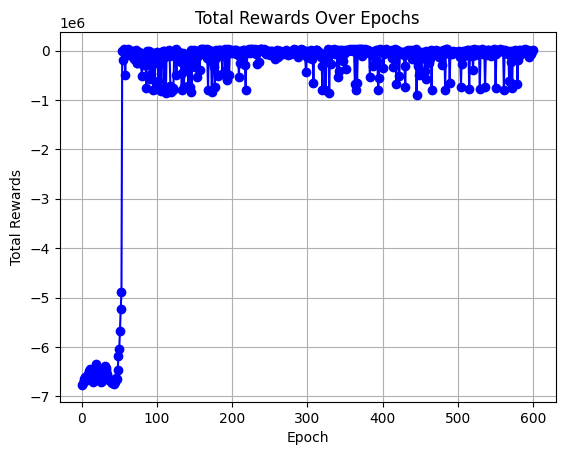

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs + 1), total_rewards, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Total Rewards')
plt.title('Total Rewards Over Epochs')
plt.grid()
plt.show()

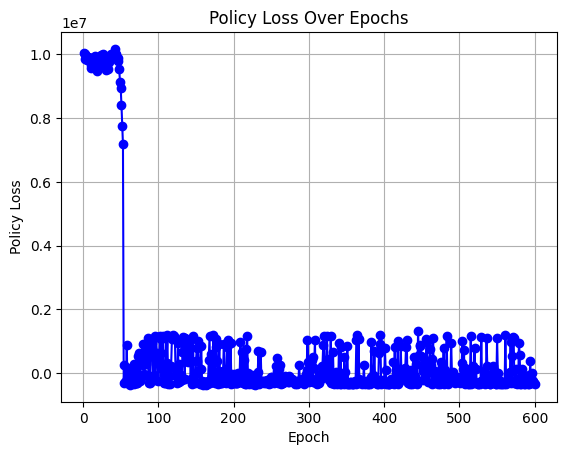

In [13]:
plt.plot(range(1, num_epochs + 1), policy_losses, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Policy Loss')
plt.title('Policy Loss Over Epochs')
plt.grid()
plt.show()

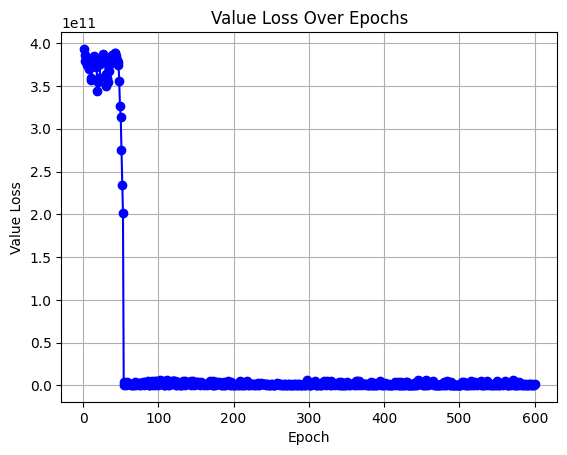

In [14]:
plt.plot(range(1, num_epochs + 1), value_losses, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Value Loss')
plt.title('Value Loss Over Epochs')
plt.grid()
plt.show()